## 데이터세트

In [1]:
import os
import torch
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset

In [2]:
# root : /home/jovyan/lifecare_project/data/processed_data
class CustomDataset(Dataset):
    def __init__(self,root,train,transform = None):
        super().__init__()
        directory = "train" if train else "val"
        annotations = os.path.join(root,"annotations", f"{directory}_coco.json")

        self.coco =COCO(annotations)
        self.image_path = os.path.join(root,directory)
        self.transform = transform

        self.categories = self._get_categories()
        self.data = self._load_data()

    def _get_categories(self):
        categories = {0: "background"}
        for category in self.coco.cats.values():
            categories[category["id"]] = category["name"]
        return categories

    def _load_data(self) : 
        data = []
        for _id in self.coco.imgs:
            file_name = self.coco.loadImgs(_id)[0]["file_name"] #개별파일이름
            image_path = os.path.join(self.image_path,file_name) #개별파일 경로
            image = Image.open(image_path)#.convert("RGB") #바꿀필요있나 그레이스케일인데

            boxes = []
            labels = []
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            for ann in anns : 
                x,y,w,h = ann["bbox"]
                boxes.append([x,y,x+w,y+h])
                labels.append(ann["category_id"])

            target = {
                "image_id" : torch.LongTensor([_id]),
                "boxes" : torch.FloatTensor(boxes),
                "labels" : torch.LongTensor(labels)
            }
            data.append([image,target])
        return data


    def __getitem__(self,index):
        image,target = self.data[index]
        if self.transform : 
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.data)


## 데이터로더

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def collator(batch):
    return tuple(zip(*batch))

In [6]:
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

In [6]:
train_dataset = CustomDataset('/home/jovyan/lifecare_project/data/processed_data', train = True, transform = transform)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [7]:
train_dataset.data

[[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024>,
  {'image_id': tensor([1]),
   'boxes': tensor([[113., 113., 390., 821.],
           [577., 205., 748., 452.]]),
   'labels': tensor([1, 1])}],
 [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024>,
  {'image_id': tensor([2]),
   'boxes': tensor([[585., 515., 859., 758.]]),
   'labels': tensor([1])}],
 [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024>,
  {'image_id': tensor([3]),
   'boxes': tensor([[762., 523., 835., 617.]]),
   'labels': tensor([1])}],
 [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024>,
  {'image_id': tensor([4]),
   'boxes': tensor([[592., 314., 869., 888.],
           [276., 552., 470., 837.]]),
   'labels': tensor([1, 1])}],
 [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1024x1024>,
  {'image_id': tensor([5]),
   'boxes': tensor([[600., 300., 931., 846.],
           [235., 283., 518., 906.]]),
   'labels': tensor([1, 1])}],
 [<PIL.JpegImagePlugin.Jp

In [7]:
test_dataset = CustomDataset('/home/jovyan/lifecare_project/data/processed_data', train = False, transform = transform)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [8]:
train_dataloader = DataLoader( train_dataset, batch_size= 1, shuffle= True, drop_last= True, collate_fn= collator )

In [8]:
test_dataloader = DataLoader( test_dataset, batch_size= 1, shuffle= True, drop_last= True, collate_fn= collator )

In [11]:
print(len(train_dataloader))

1228


## 모델정의하기

In [9]:
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

In [10]:
backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features

In [11]:
backbone.out_channels = 512

In [12]:
anchor_generator = rpn.AnchorGenerator(
    sizes = ((32,64,128,256,512),),
    aspect_ratios = ((0.5,1.0,2.0),)
)

roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names= ["0"],
    output_size = (7,7),
    sampling_ratio =  2
)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FasterRCNN(
    backbone=backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool = roi_pooler
).to(device)

In [14]:
#최적화 함수 및 스케줄러
from torch import optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr = 0.001, momentum= 0.9, weight_decay= 0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma = 0.1)

In [ ]:
#모델학습 
epoch_num = 10
for epoch in range(epoch_num):
    cost = 0.0
    for idx, (images,targets) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k :v.to(device) for k , v in t.items()} for t in targets]

        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        cost+=losses

    lr_scheduler.step()
    cost = cost/len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 0.278


In [15]:
# epoch_num = 1
# for epoch in range(epoch_num):
#     cost = 0.0
#     for idx, (images, targets) in enumerate(train_dataloader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # 모델로부터 손실값 계산
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         # 옵티마이저 및 기울기 계산
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         # 중간 결과 출력
#         cost += losses

#         if (idx + 1) % 10 == 0:  # 예를 들어, 10번째 배치마다 출력
#             print(f"Epoch: {epoch + 1}, Batch: {idx + 1}, Loss: {losses.item():.4f}")

#     lr_scheduler.step()
#     cost = cost / len(train_dataloader)
#     print(f"Epoch: {epoch + 1:4d}, Cost: {cost:.3f}")


Epoch: 1, Batch: 10, Loss: 1.1421
Epoch: 1, Batch: 20, Loss: 0.7767
Epoch: 1, Batch: 30, Loss: 0.6096
Epoch: 1, Batch: 40, Loss: 0.4034
Epoch: 1, Batch: 50, Loss: 0.2408
Epoch: 1, Batch: 60, Loss: 0.2746
Epoch: 1, Batch: 70, Loss: 0.3439
Epoch: 1, Batch: 80, Loss: 0.1800
Epoch: 1, Batch: 90, Loss: 0.3421
Epoch: 1, Batch: 100, Loss: 0.2645
Epoch: 1, Batch: 110, Loss: 0.3120
Epoch: 1, Batch: 120, Loss: 0.3179
Epoch: 1, Batch: 130, Loss: 0.2809
Epoch: 1, Batch: 140, Loss: 0.2930
Epoch: 1, Batch: 150, Loss: 0.1340
Epoch: 1, Batch: 160, Loss: 0.2212
Epoch: 1, Batch: 170, Loss: 0.3845
Epoch: 1, Batch: 180, Loss: 0.1688
Epoch: 1, Batch: 190, Loss: 0.3575
Epoch: 1, Batch: 200, Loss: 0.2239
Epoch: 1, Batch: 210, Loss: 0.2741
Epoch: 1, Batch: 220, Loss: 0.3364
Epoch: 1, Batch: 230, Loss: 0.2562
Epoch: 1, Batch: 240, Loss: 0.1760
Epoch: 1, Batch: 250, Loss: 0.2814
Epoch: 1, Batch: 260, Loss: 0.3093
Epoch: 1, Batch: 270, Loss: 0.2507
Epoch: 1, Batch: 280, Loss: 0.2528
Epoch: 1, Batch: 290, Loss: 0

In [15]:
#테스트

import torch
import gc
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

# 초기화
epoch_num = 10
scaler = GradScaler()  # Mixed Precision Training을 위한 GradScaler

for epoch in range(epoch_num):
    cost = 0.0
    for idx, (images, targets) in enumerate(train_dataloader):
        # 이미지와 타겟을 GPU로 전송
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Mixed Precision Training 사용
        with autocast():  # mixed precision에서 자동으로 FP16으로 변환
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # 기울기 초기화, 역전파 및 파라미터 갱신
        optimizer.zero_grad()
        scaler.scale(losses).backward()  # loss 값에 대해 backward() 호출 (scaled)
        scaler.step(optimizer)  # 최적화 진행
        scaler.update()  # scaler 업데이트

        cost += losses.item()

        # 메모리 정리
        del images, targets, loss_dict, losses
        torch.cuda.empty_cache()  # GPU 메모리 비우기
        gc.collect()  # Python 가비지 컬렉션

    lr_scheduler.step()  # 학습률 스케줄러 업데이트
    cost = cost / len(train_dataloader)  # 평균 비용 계산
    print(f"Epoch : {epoch + 1:4d}, Cost : {cost:.3f}")



Epoch :    1, Cost : 0.250
Epoch :    2, Cost : 0.236
Epoch :    3, Cost : 0.230
Epoch :    4, Cost : 0.227
Epoch :    5, Cost : 0.222
Epoch :    6, Cost : 0.221
Epoch :    7, Cost : 0.219
Epoch :    8, Cost : 0.218
Epoch :    9, Cost : 0.217
Epoch :   10, Cost : 0.215


In [ ]:
# 학습 후 모델 저장
torch.save(model.state_dict(), 'fasterrcnn_model.pth')


## 평가

In [9]:
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512
anchor_generator = rpn.AnchorGenerator(
    sizes = ((32,64,128,256,512),),
    aspect_ratios = ((0.5,1.0,2.0),)
)

roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names= ["0"],
    output_size = (7,7),
    sampling_ratio =  2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FasterRCNN(
    backbone=backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool = roi_pooler
).to(device)



In [10]:
# 저장된 모델 가중치 불러오기
model.load_state_dict(torch.load('fasterrcnn_model.pth'))
model.eval()  # 평가 모드로 전환


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [ ]:
# import numpy as np
# from pycocotools.cocoeval import COCOeval


# with torch.no_grad():
#     model.eval()
#     custom_detections = []
#     for images, targets in test_dataloader:
#         images = [img.to(device) for img in images]
#         outputs = model(images)

#         for i in range(len(targets)):
#             image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
#             boxes = outputs[i]["boxes"].data.cpu().numpy()
#             boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
#             boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
#             scores = outputs[i]["scores"].data.cpu().numpy()
#             labels = outputs[i]["labels"].data.cpu().numpy()

#             for instance_id in range(len(boxes)):
#                 box = boxes[instance_id, :].tolist()
#                 prediction = np.array(
#                     [
#                         image_id,
#                         box[0],
#                         box[1],
#                         box[2],
#                         box[3],
#                         float(scores[instance_id]),
#                         int(labels[instance_id]),
#                     ]
#                 )
#                 custom_detections.append(prediction)

#     custom_detections = np.asarray(custom_detections)
#     custom_gt = test_dataloader.dataset.coco
#     custom_dt = custom_gt.loadRes(custom_detections)
#     custom_evaluator = COCOeval(custom_gt, custom_dt, iouType="bbox")
#     custom_evaluator.evaluate()
#     custom_evaluator.accumulate()
#     custom_evaluator.summarize()

In [11]:
##테스ㅡㅇ임
import numpy as np
from pycocotools.cocoeval import COCOeval
import torch
import gc

model.eval()
custom_detections = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            # 낮은 점수 필터링
            threshold = 0.5
            keep_indices = scores > threshold
            boxes = boxes[keep_indices]
            scores = scores[keep_indices]
            labels = labels[keep_indices]

            # Bounding box 크기 변환
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = [
                    image_id,
                    box[0],
                    box[1],
                    box[2],
                    box[3],
                    float(scores[instance_id]),
                    int(labels[instance_id]),
                ]
                custom_detections.append(prediction)

        # 메모리 정리
        torch.cuda.empty_cache()
        gc.collect()

custom_detections = np.asarray(custom_detections)

# COCO API 호출
custom_gt = test_dataloader.dataset.coco
custom_dt = custom_gt.loadRes(custom_detections)
custom_evaluator = COCOeval(custom_gt, custom_dt, iouType="bbox")
custom_evaluator.evaluate()
custom_evaluator.accumulate()
custom_evaluator.summarize()


Loading and preparing results...
Converting ndarray to lists...
(3124, 7)
0/3124
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Recall    

## 추론 및 시각화

In [12]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [13]:
def draw_bbox(ax, box, text, color):
    ax.add_patch(
        plt.Rectangle(
            xy = (box[0],box[1]),
            width=box[2]-box[0],
            height = box[3]-box[1],
            fill=False,
            edgecolor = color,
            linewidth = 2,)
)
    ax.annotate(
        text = text,
        xy = (box[0] -5, box[1] -5),
        color = color,
        weight = 'bold',    
        fontsize = 13
    )

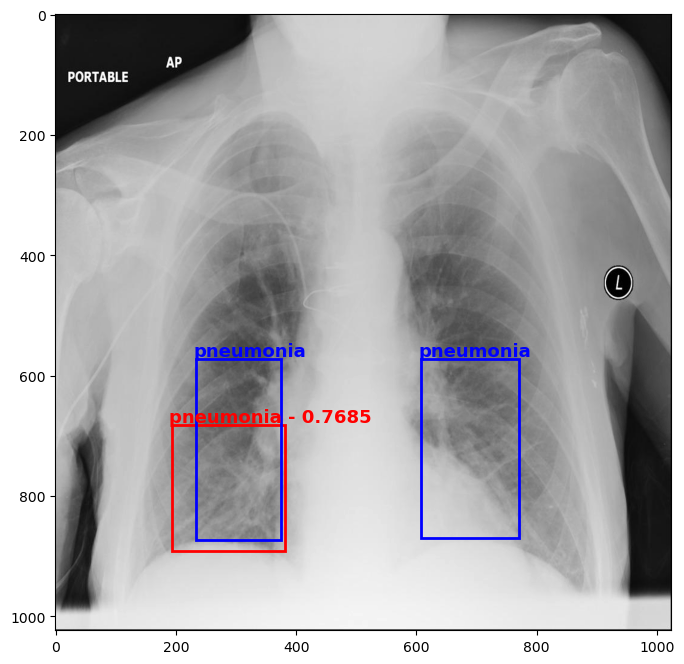

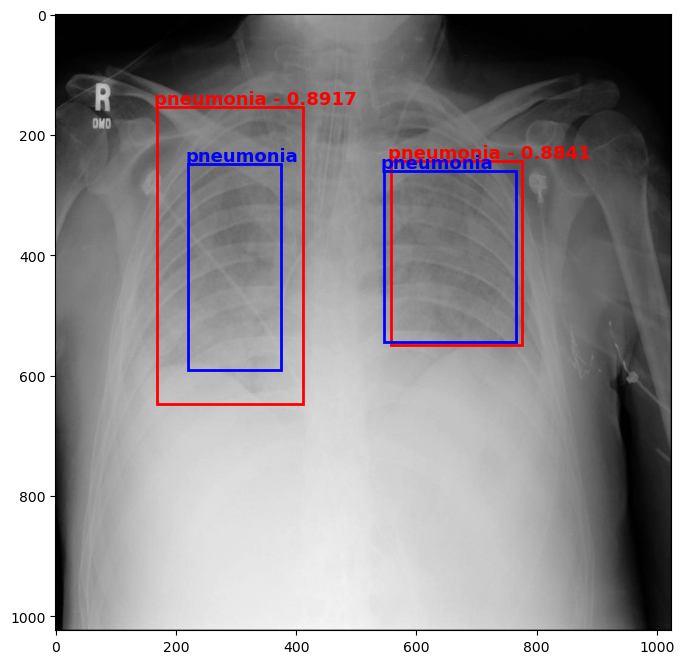

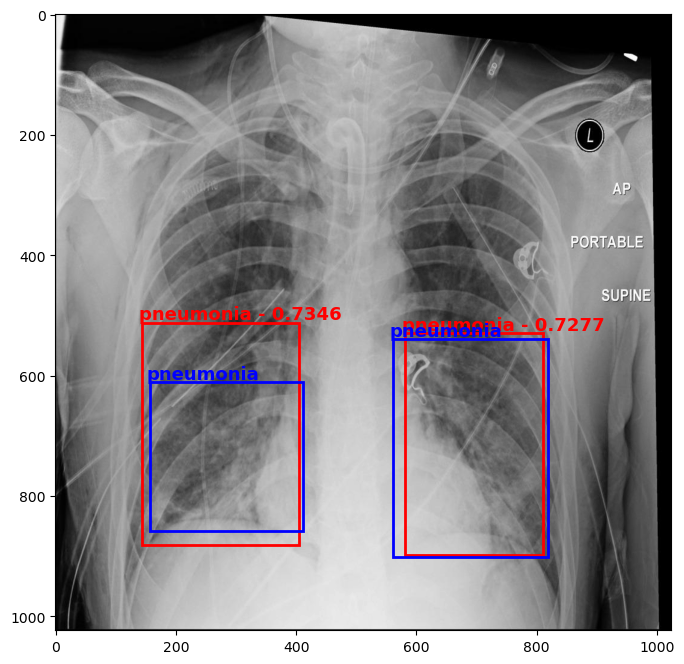

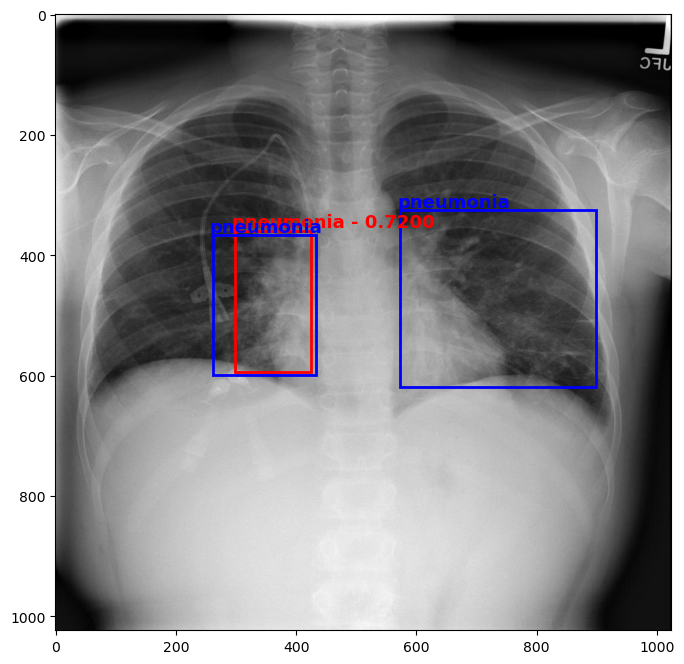

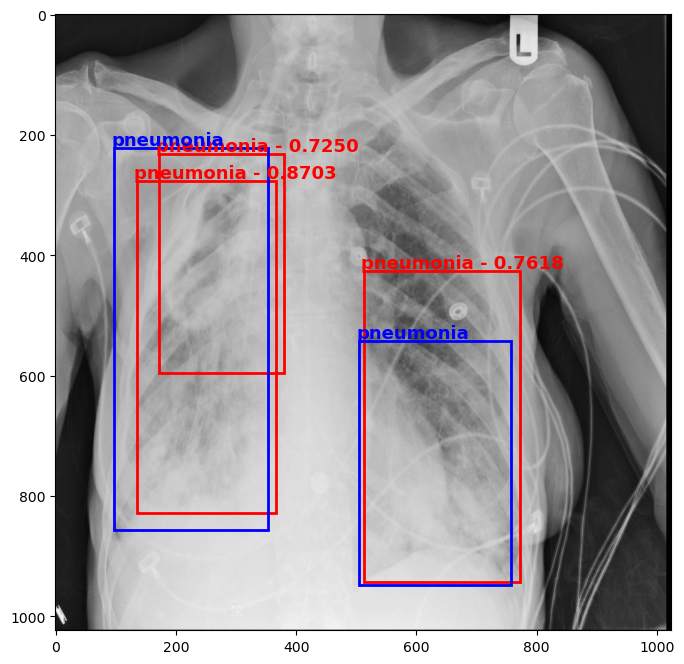

In [16]:
threshold = 0.7
categories = test_dataset.categories
num_images_to_show = 5  # 시각화할 이미지 수

with torch.no_grad():
    model.eval()
    image_count = 0  # 시각화한 이미지 수 카운팅
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        # 이미지 시각화 (그레이스케일)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0], mode="L"), cmap="gray")

        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()

        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")

        plt.show()

        image_count += 1
        if image_count >= num_images_to_show:
            break  # 설정한 수만큼 이미지를 출력한 후 종료


In [ ]:
# threshold = 0.5
# categories = test_dataset.categories
# with torch.no_grad():
#     model.eval()
#     for images, targets in test_dataloader:
#         images = [image.to(device) for image in images]
#         outputs = model(images)

#         boxes = outputs[0]["boxes"].to("cpu").numpy()
#         labels = outputs[0]["labels"].to("cpu").numpy()
#         scores = outputs[0]["scores"].to("cpu").numpy()

#         boxes = boxes[scores >= threshold].astype(np.int32)
#         labels = labels[scores >= threshold]
#         scores = scores[scores >= threshold]

#         fig = plt.figure(figsize = (8,8))
#         ax = fig.add_subplot(1,1,1)
#         plt.imshow(to_pil_image(images[0]))

#         for box, label, score in zip(boxes, labels, scores):
#             draw_bbox(ax,box,f"{categories[label]} - {score:.4f}", "red")

#         tboxes = targets[0]["boxes"].numpy()
#         tlabels = targets[0]["labels"].numpy()

#         for box, label in zip(tboxes, tlabels):
#             draw_bbox(ax,box,f"{categories[label]}","blue")

#         plt.show()
            

In [ ]:
# import numpy as np
# from pycocotools.cocoeval import COCOeval

# with torch.no_grad():
#     model.eval()
#     custom_detections = []
#     for images, targets in test_dataloader:
#         images = [img.to(device) for img in images]
#         outputs = model(images)

#         for i in range(len(targets)):
#             image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
#             boxes = outputs[i]["boxes"].data.cpu().numpy()
#             boxes[:, 2] = boxes[:, 2] - boxes[:, 0]  # width 계산
#             boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  # height 계산
#             scores = outputs[i]["scores"].data.cpu().numpy()
#             labels = outputs[i]["labels"].data.cpu().numpy()

#             for instance_id in range(len(boxes)):
#                 box = boxes[instance_id, :].tolist()
#                 prediction = np.array(
#                     [
#                         image_id,
#                         box[0],
#                         box[1],
#                         box[2],
#                         box[3],
#                         float(scores[instance_id]),
#                         int(labels[instance_id]),
#                     ]
#                 )
#                 custom_detections.append(prediction)

#     custom_detections = np.asarray(custom_detections)
#     custom_gt = test_dataloader.dataset.coco
#     custom_dt = custom_gt.loadRes(custom_detections)
#     custom_evaluator = COCOeval(custom_gt, custom_dt, iouType="bbox")
#     custom_evaluator.evaluate()
#     custom_evaluator.accumulate()
#     custom_evaluator.summarize()
